In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5099371268234668984
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3076812800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15005895206477730617
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [4]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Food 속성 리뷰
url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,2777,"To be completely fair, the only redeeming fact...",food,1
1,1634,"The food is uniformly exceptional, with a very...",food,1
2,2846,"Not only was the food outstanding, but the lit...",food,1
3,1571,It is very overpriced and not very tasty.,food,0
4,1458,Our agreed favorite is the orrechiete with sau...,food,1


In [5]:
df.dtypes

id          object
text        object
category    object
polarity     int64
dtype: object

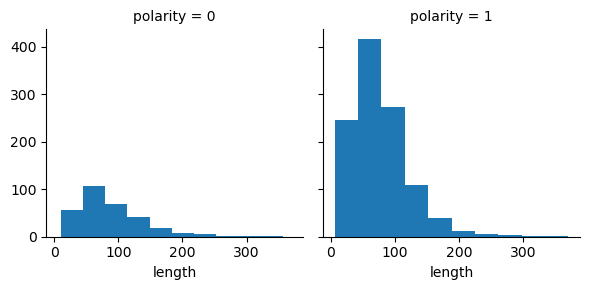

In [6]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [7]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 1107, negative: 308


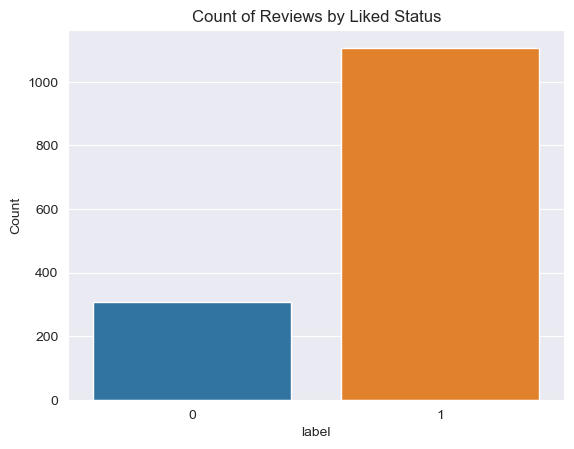

In [8]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [9]:
df_new.length.describe()

count    1415.000000
mean       79.168198
std        46.640079
min         6.000000
25%        47.500000
50%        70.000000
75%       102.000000
max       370.000000
Name: length, dtype: float64

In [10]:
text = df.text.values
labels = df.polarity.values

In [11]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [12]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [13]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 1132
validation: 283


In [14]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [15]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:   7%|█████                                                                       | 1/15 [00:12<02:55, 12.55s/it]


	 - Train loss: 0.3524
	 - Validation Accuracy: 0.9132


Epoch:  13%|██████████▏                                                                 | 2/15 [00:23<02:28, 11.44s/it]


	 - Train loss: 0.1820
	 - Validation Accuracy: 0.9062


Epoch:  20%|███████████████▏                                                            | 3/15 [00:33<02:12, 11.06s/it]


	 - Train loss: 0.1157
	 - Validation Accuracy: 0.8993


Epoch:  27%|████████████████████▎                                                       | 4/15 [00:44<01:59, 10.84s/it]


	 - Train loss: 0.0817
	 - Validation Accuracy: 0.8819


Epoch:  33%|█████████████████████████▎                                                  | 5/15 [00:54<01:47, 10.72s/it]


	 - Train loss: 0.0410
	 - Validation Accuracy: 0.9132


Epoch:  40%|██████████████████████████████▍                                             | 6/15 [01:05<01:35, 10.66s/it]


	 - Train loss: 0.0140
	 - Validation Accuracy: 0.9062


Epoch:  47%|███████████████████████████████████▍                                        | 7/15 [01:15<01:24, 10.61s/it]


	 - Train loss: 0.0205
	 - Validation Accuracy: 0.9132


Epoch:  53%|████████████████████████████████████████▌                                   | 8/15 [01:26<01:14, 10.58s/it]


	 - Train loss: 0.0174
	 - Validation Accuracy: 0.9028


Epoch:  60%|█████████████████████████████████████████████▌                              | 9/15 [01:36<01:03, 10.57s/it]


	 - Train loss: 0.0807
	 - Validation Accuracy: 0.8924


Epoch:  67%|██████████████████████████████████████████████████                         | 10/15 [01:47<00:52, 10.56s/it]


	 - Train loss: 0.0390
	 - Validation Accuracy: 0.9028


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 11/15 [01:58<00:42, 10.55s/it]


	 - Train loss: 0.0067
	 - Validation Accuracy: 0.8993


Epoch:  80%|████████████████████████████████████████████████████████████               | 12/15 [02:08<00:31, 10.55s/it]


	 - Train loss: 0.0378
	 - Validation Accuracy: 0.8924


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 13/15 [02:19<00:21, 10.55s/it]


	 - Train loss: 0.0195
	 - Validation Accuracy: 0.9132


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 14/15 [02:29<00:10, 10.55s/it]


	 - Train loss: 0.0058
	 - Validation Accuracy: 0.9097


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 15/15 [02:40<00:00, 10.68s/it]


	 - Train loss: 0.0387
	 - Validation Accuracy: 0.9062


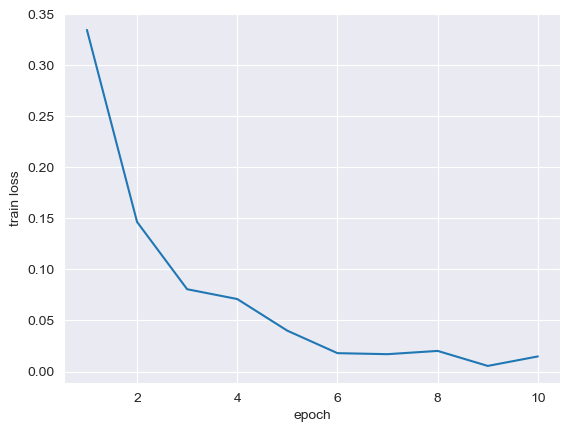

In [16]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

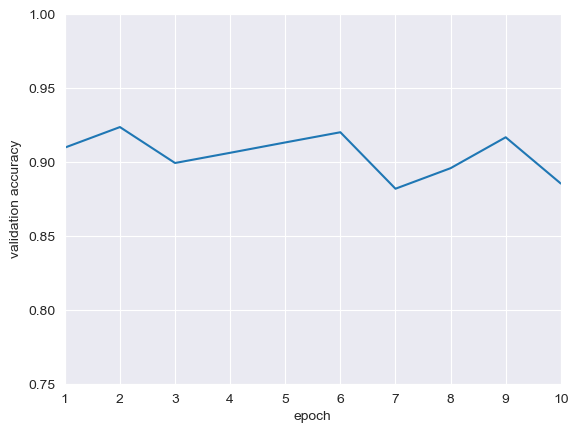

In [17]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [17]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [18]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,3440,"Even though its good seafood, the prices are t...",aa,1
1,en_CatalRestaurant__UvaBar_477861889:4,My g/f and I both agreed the food was very med...,food,0
2,1242,But the coconut rice was good.,food,1
3,en_BlueRibbonSushi_478218345:2,It has great sushi and even better service.,food,1
4,882,"While the ambiance and atmosphere were great, ...",food,0


In [19]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 46, negative: 34


In [20]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

wrongResult=[]
rightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        rightResult.append(t)
    else:
        wrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
Even though its good seafood, the prices are too high.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
My g/f and I both agreed the food was very mediocre especially considering the price.
model result: Positive 
answer: 0 

=============================== Input 3 ===============================
But the coconut rice was good.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It has great sushi and even better service.
model result: Positive 
answer: 1 

=============================== Input 5 ===============================
While the ambiance and atmosphere were great, the food and service could have been a lot better.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The food was lousy -too sweet or too salty and the portions tiny.
model res

=============================== Input 74 ===============================
The food was great.
model result: Positive 
answer: 1 

=============================== Input 75 ===============================
I swore never to return for a warm beer and mediocre meal.
model result: Negative 
answer: 0 

=============================== Input 76 ===============================
Don't leave the restaurant without it.
model result: Negative 
answer: 1 

=============================== Input 77 ===============================
The onion rings are great!
model result: Positive 
answer: 1 

=============================== Input 78 ===============================
Good food!
model result: Positive 
answer: 1 

=============================== Input 79 ===============================
With the theater 2 blocks away we had a delicious meal in a beautiful room.
model result: Positive 
answer: 1 

=============================== Input 80 ===============================
very good breads as well.
model result: P

In [21]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [22]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [23]:
# 개별 문장의 attention 추출
from bertviz import head_view

sent="Terrible service, but food was delicious, and cost-effective."

# 전처리
encoding = preprocessing(sent, tokenizer,20)


retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

print('입력 문장:', sent)
print('분류:', prediction)
print()

#head_view(retAtt,retTok)


입력 문장: Terrible service, but food was delicious, and cost-effective.
분류: Positive



In [24]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [25]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [26]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [27]:
# 개별 문장을 attention이 높은 token 순으로 보여주기
idxs=sort_by_att(retLastAtt,retTok)

emp_by_att(idxs,retTok)

get_highest_att_tok(idxs,retTok,3)

========================= emphasize by attention result==========================
terrible service , but food was delicious , and cost - effective . 
highest attention: terrible delicious effective 

In [36]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: While the ambiance and atmosphere were great, the food and service could have been a lot better.
분류: Positive
MAX_LEN:  23
========================= emphasize by attention result==========================
while the am ##bian ##ce and atmosphere were great , the food and service could have been a lot better . 
highest attention: food atmosphere service great 



입력 문장: I have been here, spent tons of money on a chef special dinner and it was a major dissappointment.
분류: Positive
MAX_LEN:  27
========================= emphasize by attention result==========================
i have been here , spent tons of money on a chef special dinner and it was a major di ##ssa ##pp ##oint ##ment . 
highest attention: ##pp tons di major 



입력 문장: I liked the atmosphere very much but the food was not worth the price.
분류: Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
i liked the atmosphere very much but the food was not worth the price . 


In [37]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_food_test.csv'
df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,180,food,"쟁반짜장은 너무 짜고, 면이 불어 있었어요\n탕수육은 비린내가 심하고, 짬뽕은 양파...",0,The jajangmyeon on the tray was too salty and ...
1,1,580,food,매장이 엄청 지저분합니다.\n사이다는 단맛이 하나도 없는 탄산수였습니다.\n직원이 ...,0,The store is really messy.. Sprite was carbona...
2,2,605,food,고기 기름이 넘 많네요\n서비스도 조금 부족한듯\n다소 아쉽네요,0,There's too much meat oil. The service seems t...
3,3,1696,food,토마호크 비추천.\n고기가 질김,0,I don't recommend Tomahawk.. the toughness of ...
4,4,2550,food,스테이크덮밥이랑 큐브스테이크덮밥을 먹엇는데 개인적으로 다음식 안좋아하는 분은 큐브스...,0,I ate rice with steak and rice with cube steak...


In [41]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count     80.000000
mean     120.200000
std       51.804745
min       30.000000
25%       69.750000
50%      119.500000
75%      163.250000
max      226.000000
Name: length, dtype: float64

In [38]:
# naver data에 대한 분류 및 accuracy 측정
count=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))

=============================== Input 1 ===============================
The jajangmyeon on the tray was too salty and the noodles were swollen. Tangsuyuk had a bad fishy smell, jjamppong had a lot of onions, and squid had only 3 pieces
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
There's too much meat oil. The service seems to be a little lacking. It's a bit disappointing
model result: Negative 
answer: 0 

=============================== Input 4 ===============================
I don't recommend Tomahawk.. the toughness of the meat
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
I ate rice with steak and rice with cube steak, but personally,

=============================== Input 42 ===============================
The bread is chewy. It's delicious. It hasn't been long since it opened, so the baker's. I think it's more passionate.. . Warm bread made by warm people. Try it~~^^
model result: Positive 
answer: 1 

=============================== Input 43 ===============================
The quality of the meat and the tempura are very fresh and delicious.. I can't help but write a review... Thank you!
model result: Positive 
answer: 1 

=============================== Input 44 ===============================
It's kind and the oil is clean and crispy and delicious The members really liked it The delivery time is a bit long, so I think I need to order it in advance That's the only thing that's unfortunate
model result: Positive 
answer: 1 

=============================== Input 45 ===============================
The cost-effectiveness is the best and it's so delicious..
model result: Positive 
answer: 1 

========================

In [39]:
#잘못 분류된 문장의 attention
for sent in NaverWrongResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: Maybe it's just meat. But I can't eat soybean paste with crab. It's too fishy The bibim sauce for naengmyeon is not that bad, but the broth is... Wow..It's a taste I don't want to eat again
분류: Positive
MAX_LEN:  67
========================= emphasize by attention result==========================
maybe it ' s just meat . but i can ' t eat soy ##be ##an paste with crab . it ' s too fish ##y the bi ##bi ##m sauce for na ##eng ##my ##eon is not that bad , but the bro ##th is . . . wow . . it ' s a taste i don ' t want to eat again 
highest attention: ' ' bi ##bi 



입력 문장: Far from green onion kimchi, cabbage kimchi has fallen... It's greasy to my taste...  I have no intention of revisiting.
분류: Positive
MAX_LEN:  36
========================= emphasize by attention result==========================
far from green onion kim ##chi , cabbage kim ##chi has fallen . . . it ' s greasy to my taste . . . i have no intention of rev ##isi ##ting . 
highest attention: kim kim ##chi green 



입

In [40]:
#잘 분류된 문장의 attention
for sent in NaverRightResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: The jajangmyeon on the tray was too salty and the noodles were swollen. Tangsuyuk had a bad fishy smell, jjamppong had a lot of onions, and squid had only 3 pieces
분류: Negative
MAX_LEN:  47
========================= emphasize by attention result==========================
the ja ##jan ##gm ##ye ##on on the tray was too salty and the noodles were swollen . tang ##su ##yu ##k had a bad fish ##y smell , jj ##amp ##pon ##g had a lot of onions , and squid had only 3 pieces 
highest attention: and and pieces were 



입력 문장: The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
분류: Negative
MAX_LEN:  29
========================= emphasize by attention result==========================
the store is really messy . . sp ##rite was carbonate ##d water without any sweetness . . there seemed to be a shortage of staff . 
highest attention: seemed to there be 



입력 문장: There's too much meat oil. The service seems to be a little l

========================= emphasize by attention result==========================
not until long ago . the owner changed and the taste changed 
highest attention: and ago changed changed 



입력 문장: as if it's not seasoned enough
분류: Negative
MAX_LEN:  10
========================= emphasize by attention result==========================
as if it ' s not seasoned enough 
highest attention: as enough if not 



입력 문장: The food is a bit salty. Rice and curry are refilled
분류: Negative
MAX_LEN:  16
========================= emphasize by attention result==========================
the food is a bit salty . rice and curry are ref ##ille ##d 
highest attention: ##d a the are 



입력 문장: I've been to this place often, and I love that there's a cafe like this in the neighborhood!! The interior is clean, the coffee is delicious, and corn cheese toast is especially delicious!!
분류: Positive
MAX_LEN:  46
========================= emphasize by attention result==========================
i ' ve been to thi

========================= emphasize by attention result==========================
even though it was a weekday evening , the atmosphere was amazing . . but sun ##dae ##gu ##k was so delicious that i could endure and wait . i want to eat it with so ##ju next time ! i did it again today ! 
highest attention: atmosphere it was amazing 



입력 문장: I've been waiting for 40 minutes for lunch on Saturday It wasn't enough But it's not greasy and it's
분류: Positive
MAX_LEN:  29
========================= emphasize by attention result==========================
i ' ve been waiting for 40 minutes for lunch on saturday it wasn ' t enough but it ' s not greasy and it ' s 
highest attention: ' waiting but 40 



입력 문장: I broke my promise with my friend to eat something simple Salted pollack pasta is so delicious and lasagna is the best    It makes me think that I'm home Strongly recommended
분류: Positive
MAX_LEN:  39
========================= emphasize by attention result==========================
i brok

========================= emphasize by attention result==========================
the pork belly was really good , but the pork neck was crazy ! ! ! i ' m amazed as soon as i eat it do you really recommend it ! ! ! ! it ' s so nice that the staff cooked it delicious ##ly . i ' ll save it as a good restaurant 
highest attention: ' ' staff was 



입력 문장: He was kind and the drink was very delicious! The side tastes good, too
분류: Positive
MAX_LEN:  18
========================= emphasize by attention result==========================
he was kind and the drink was very delicious ! the side tastes good , too 
highest attention: side tastes delicious good 



입력 문장: Parking is a little inconvenient, but the atmosphere of the store is so good and all the menus are delicious :)
분류: Positive
MAX_LEN:  29
========================= emphasize by attention result==========================
parking is a little inc ##on ##ven ##ient , but the atmosphere of the store is so good and all the menu ##s are d

========================= emphasize by attention result==========================
it ' s good , but the staff members are kind . . . i understand if it ' s because you ' re busy . . 
highest attention: ' s good but 



입력 문장: It's clean and delicious. It's a shame that the price went up
분류: Positive
MAX_LEN:  19
========================= emphasize by attention result==========================
it ' s clean and delicious . it ' s a shame that the price went up 
highest attention: clean delicious s and 



입력 문장: The food was delicious and the staff were very kind, so I had a nice meal. It's nice to have a seat for Da-Ji!
분류: Positive
MAX_LEN:  33


KeyboardInterrupt: 

In [44]:
#NAVER final test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_fin_food_trans.csv'
df = pd.read_csv(test_url,sep=',', header=0)
df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,0,taste,요즘 평양냉면 제대로 하는집이 많지 않은데 여긴 찐입니다???? 자극적이지 않은데 ...,1,There aren't many restaurants that make Pyeong...
1,1,2,taste,평양냉면 맛도 잘 모르고 갔다가 맛보고 헉~했어요 너무 밍밍했거든요\n건강한 맛인거...,1,I didn't even know the taste of Pyeongyang nae...
2,2,3,taste,"평양냉면이 정말 맛있어요…????평양냉면, 온반 하나씩 시켜서 먹었는데 온반은 삼삼...",1,Pyeongyang naengmyeon is really delicious...I ...
3,3,4,taste,맛있어요~\n근데 오랜만에 갔더니 녹두전 사이즈가 줄어서 놀랐어요 ㅠㅠ,1,It's good. But I was surprised that the size o...
4,4,5,taste,맛있게 먹었습니다\n부담없는 맛과 국물이에요,1,I enjoyed my meal. It's easy to taste and soup


In [45]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count    156.00000
mean      99.00641
std      140.91180
min        9.00000
25%       17.00000
50%       45.00000
75%      110.50000
max      784.00000
Name: length, dtype: float64

In [46]:
# naver data에 대한 분류 및 accuracy 측정
count=0

negNum=0
posNum=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
        negNum+=1
    else:
        result=1
        posNum+=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
print("Positive ratio: {:.4f}".format(posNum/len(test_labels)))
print("Negative ratio: {:.4f}".format(negNum/len(test_labels)))

=============================== Input 1 ===============================
There aren't many restaurants that make Pyeongyang naengmyeon properly these days, but this place is real??? It's not stimulating, but it has a deep taste. I'm so full, but I ate it until the end?? It seemed like she was making all the side dishes herself!! The store is spacious and clean, so I think it'll be good for group gatherings!! It's my first time seeing a restaurant with a spacious and clean bathroom like Evaluationok. The hygiene and taste are the best???
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
I didn't even know the taste of Pyeongyang naengmyeon, so I tasted it and gasped It was too bland. I think it's a healthy taste, but it wasn't good for my taste The mung bean pancake was too small and thin for the price
model result: Negative 
answer: 1 

=============================== Input 3 ===============================
Pyeongyang naengmyeon 

=============================== Input 51 ===============================
It's good. It's good for adults to children
model result: Positive 
answer: 1 

=============================== Input 52 ===============================
I went there for Parents' Day, and the kindness and hygiene were not good for the price. They don't keep the waiting order, so they wait for more than 40 minutes and the food is busy, so they tell me to cook it on my own, and the naengmyeon is tasteless.. Dumplings are not that..Bulgogi was delicious. But the employee's unkindness...I don't think I'll go twice.
model result: Positive 
answer: 0 

=============================== Input 53 ===============================
It's a bit salty
model result: Negative 
answer: 0 

=============================== Input 54 ===============================
It's good
model result: Positive 
answer: 1 

=============================== Input 55 ===============================
Pyeongyang naengmyeon restaurant
model result: Positive 

=============================== Input 114 ===============================
Three times in a weekThere's a lot of onban and it's so good My family doesn't have a lot, so if you buy one, your family will eat it Hahaha
model result: Positive 
answer: 1 

=============================== Input 115 ===============================
It's good
model result: Positive 
answer: 1 

=============================== Input 116 ===============================
The restaurant that always eats deliciously
model result: Positive 
answer: 1 

=============================== Input 117 ===============================
Dumpling hot pot, fish cake tray, and cold noodles
model result: Positive 
answer: 1 

=============================== Input 118 ===============================
I went to eat dumpling hot pot and it was really good.. The three of us ordered two servings of hot pot and mung bean pancake, but the amount of hot pot was large, so we ate it full.. I think the meat in dumpling hot pot is good and the sou

In [34]:
#naver3 data 테스트

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/mongryen_food.csv'
df = pd.read_csv(test_url,sep=',', header=0)
df.head(5)

,id,category,text,trans_text
0,0,taste,특수부위 아주 맛있어요! 보기에는 고기가 두툼해서 질길것 같은데 정말 부드럽고 살살...,Special parts are very delicious! The meat loo...
1,1,taste,두번째 방문이예요 여전히 부드럽고 맛있는고기 만족입니다 :) 치즈듬뿍올린 볶음밥도 ...,This is my second visit I'm still satisfied wi...
2,2,taste,고기 찌개 밥 다 맛있었던 성수 맛집 몽련 !! \n가게도 깔끔하고 넓어서 회식이나...,"Mongryeon, a restaurant in Seongsu that had de..."
3,3,taste,도끼살 진짜 맛있어요!!! 통벌집맥주 달달하니 계속 들어가요ㅜㅠ 특별한날 가기도 좋...,The ax meat is really good!!! It's so sweet th...
4,4,taste,정갈한 반찬과 깨끗한 매장… 고기맛도 좋아요~~!,Neat side dishes and clean stores... I like th...


In [35]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count    769.000000
mean     142.699610
std      156.812145
min        9.000000
25%       46.000000
50%       96.000000
75%      176.000000
max      964.000000
Name: length, dtype: float64

In [36]:
# naver data에 대한 분류
count=0

negNum=0
posNum=0

test_text = df.trans_text.values

for i in range(len(test_text)):
    t = df.iloc[i].trans_text
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        negNum+=1
    else:
        posNum+=1

    print("=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction)
    print("")


print("Positive ratio: {:.4f}".format(posNum/len(test_text)))
print("Negative ratio: {:.4f}".format(negNum/len(test_text)))

=============================== Input 1 ===============================
Special parts are very delicious! The meat looks thick and tough, but it melts really soft and softly A total twist!! Doenjang jjigae is really good and there's no need for words if you wrap it with seasoned scallions and kimchi! The smoke escapes easily, so you can enjoy the meat without any inconvenience! Good
model result: Positive

=============================== Input 2 ===============================
This is my second visit I'm still satisfied with the soft and delicious meat :) I also enjoyed the fried rice with a lot of cheese!
model result: Positive

=============================== Input 3 ===============================
Mongryeon, a restaurant in Seongsu that had delicious meat stew and rice! The restaurant is clean and spacious, so it's good for company dinners and gatherings ??
model result: Positive

=============================== Input 4 ===============================
The ax meat is really good!!! I

=============================== Input 42 ===============================
It's a limited sale of 20 ax meat a day, but I was lucky to taste it! It was delicious ???. The beef brisket doenjang jjigae was also good for free! And make sure to eat herring roe fried rice~~~? So delicious
model result: Positive

=============================== Input 43 ===============================
I enjoyed the meal. I'll go again next time
model result: Positive

=============================== Input 44 ===============================
I'm not that kind, but it's delicious and okay
model result: Positive

=============================== Input 45 ===============================
I went to a company dinner because it's a good lunch restaurant, and I'm satisfied with the
model result: Positive

=============================== Input 46 ===============================
Delicious and kind. Lunch menu recommendation!
model result: Positive

=============================== Input 47 ===============================
Th

=============================== Input 110 ===============================
I enjoyed the signature ax meat! The cost-effectiveness was a bit burdensome to say it was good, and I hope you can proportionalize the order for the Cozy Free.. However, I reserved a seat for three to four people on the second floor, but there was no explanation why they gave me a seat on the first floor! It was a bit disappointing even though I made a reservation a long time ago.
model result: Positive

=============================== Input 111 ===============================
Pork is so furry I thought it was hair at first, but it looked like pig hair because it came out more than five or six.. But it wasn't a pleasant experience It's been a while since I went there, but the taste has changed a lot In particular, naengmyeon used to be an excellent taste among those eaten in Seoul, but now it comes out as just a red chili-pepper paste sauce.. I was looking forward to the taste of the past, but it's a shame that 

=============================== Input 143 ===============================
It's my first time going there, so I made a reservation and ate comfortably. The store was busy, but the staff was kind, so it was good.. I enjoyed both beef and porkHah!
model result: Positive

=============================== Input 144 ===============================
It's delicious and kind. It's spacious, so it's not crowded. It's comfortable
model result: Positive

=============================== Input 145 ===============================
It's neat and delicious!
model result: Positive

=============================== Input 146 ===============================
Each type of meat is unique and delicious??
model result: Positive

=============================== Input 147 ===============================
a clean and refreshing taste
model result: Positive

=============================== Input 148 ===============================
It was delicious! It's good for a group gathering!
model result: Positive

==============

=============================== Input 209 ===============================
A place I often saw and passed by to live nearby. A place I've always wanted to visit because there are so many customers. The groom made a reservation at Mongryeon after work. Date ^^ The taste of side dishes was clean and fresh. I fell in love with the taste of beef brisket soybean paste stew, and ax meat + whole bee house draft beer is the best!! Herring roe fried rice looks goodWhatever ^^ It's so good. To be honest, I'm so.. Omok set. Tempting Kkajeong. You're the best!!! Fresh, meaty charcoal..This is perfect. Taste~Tip ♡. We don't eat it when it's salty, but we all fall in love~^^. The seat where I sat was a little hot because there was no wind. Move to the groom's side and eat all the food lol~ Pull your stomach and don't come out lol~
model result: Positive

=============================== Input 210 ===============================
It's good for a group meeting. Kind and delicious food. But the downside i

=============================== Input 278 ===============================
The meat tastes good. The side dishes are all delicious. They gave us stew, so we each had a bowl of rice
model result: Positive

=============================== Input 279 ===============================
It was a good restaurant where I introduced my friend. I really ate it deliciously.. You must eat fried rice.. Good, good
model result: Positive

=============================== Input 280 ===============================
I enjoyed the meal in a pleasant environment.. I want to come back with my friends and acquaintances on a special day
model result: Positive

=============================== Input 281 ===============================
This is my second visit.. I made a reservation for 2 weeks on my first visit.. 2FEUNG's single room is very satisfying and the serving is very kind. I felt good.. The important taste of meat is. Compared to the first one, the seasoning is too strong!!! It's even more salty because I di

=============================== Input 347 ===============================
It was so delicious ♡. I'll be back ^-^
model result: Positive

=============================== Input 348 ===============================
Thank you for the meat But it's kind of weird because the employees are smoking right in front of me
model result: Negative

=============================== Input 349 ===============================
It's delicious and nice, but if you don't open the coke-free wine, I hope you improve itI open everything else
model result: Positive

=============================== Input 350 ===============================
You can eat delicious pork
model result: Positive

=============================== Input 351 ===============================
All the meat was delicious.  Especially ax meat.  But I'd like the staff to be a little nicer. Even if you don't serve with a smile, it would have been better if you spoke softly.
model result: Positive

=============================== Input 352 =========

=============================== Input 413 ===============================
I'm satisfied with every visit. It's so good!
model result: Positive

=============================== Input 414 ===============================
I had a pork set and beef tartare, and I liked the atmosphere!! The meat was good, too
model result: Positive

=============================== Input 415 ===============================
I took my Yang's mother and they were both satisfied! It tastes good, but everything that comes out is clean and praised! I ate so well and had a great time Haha
model result: Positive

=============================== Input 416 ===============================
It's a bit expensive, but I enjoyed the food
model result: Positive

=============================== Input 417 ===============================
Only the ax meat is good. It's my fifth visit. The meat condition seems to be different from day to day. Pork belly is so bad
model result: Negative

=============================== Input 418 ==

=============================== Input 448 ===============================
I used to go there often, but when I visited this time, the price went up, the amount of food decreased, and the food was very salty, sour, spicy, and stimulating. The fried rice that I always ate was really spicy, and even though it's called nurungji, I used it because it was burnt. I often visited the restaurant when I wanted to eat meat because the menu and side dishes were delicious, but I hope I can come back to my original intention..
model result: Negative

=============================== Input 449 ===============================
It was so delicious
model result: Positive

=============================== Input 450 ===============================
The food is fine. Service and staff management are so bad After ordering the menu, they brought me things that I didn't order, and the restaurant is crowded with customers during lunch and dinner, but the staff can't manage their facial expressions. After eating on

=============================== Input 483 ===============================
It's good. But parking is not convenientHaha
model result: Positive

=============================== Input 484 ===============================
I used it during lunch time, and I ate it so deliciously. Soon, a tray of meat for dinner!!
model result: Positive

=============================== Input 485 ===============================
They prepared it on time, and they prepared it by the window. It was so nice The food on the side was so delicious that I ate it happily!
model result: Positive

=============================== Input 486 ===============================
The meat tastes good and the atmosphere is good
model result: Positive

=============================== Input 487 ===============================
The taste is not bad. It's noisy, busy, and weak..
model result: Positive

=============================== Input 488 ===============================
It was delicious!
model result: Positive

====================

=============================== Input 549 ===============================
It was delicious! I had a good time with my friend and wine with the color and a bottle of coke-free!!! The price is also cheap ??????.. I'm touched..
model result: Positive

=============================== Input 550 ===============================
Meat and soybean paste stew are delicious
model result: Positive

=============================== Input 551 ===============================
Enjoy your meal comfortably!
model result: Positive

=============================== Input 552 ===============================
I went to a nearby meat restaurant for the first time at a similar price. It's better here. The store is cleaner. I recommend it!
model result: Positive

=============================== Input 553 ===============================
I really enjoyed the meal. It was nice and kindHaha
model result: Positive

=============================== Input 554 ===============================
Marbling of meat is an art. And 

=============================== Input 615 ===============================
The parking space was a little small, but it was clean, clean, and delicious. I made a reservation on Naver and received it as a MacGoo service, so I felt really good. There were a lot of pickled vegetables wrapped in meat and a special pepper sauce was served, but it was spicy, but I kept wanting to eat it. And the pickled flower-shaped onion was also a great move. The visuals and taste are the best! People who help with serving also praise me and most of all the restrooms are really clean :). It's a place I want to revisit again
model result: Positive

=============================== Input 616 ===============================
The meat was delicious, and the sauce, side dishes, and gospel rice were all so delicious that my parents and children ate well, so I decided to go again next timeIt's not a crowded room, but it was nice because it was quiet and independent.I hope we can add steamed eggsAnyway, I'll visit a

=============================== Input 649 ===============================
I was surprised because the beef was more delicious than I thought
model result: Positive

=============================== Input 650 ===============================
I'm satisfied. Thank you for being meticulous I really enjoyed the meal.
model result: Positive

=============================== Input 651 ===============================
Fried rice is the best.. Fried rice is the best! I'm impressed.. It was 180,000 won for 5 people.. It's taking too long. The wait is frustrating.
model result: Positive

=============================== Input 652 ===============================
It's good!
model result: Positive

=============================== Input 653 ===============================
The meat is delicious and clean, but the charcoal is weak, so it takes too long to cook
model result: Positive

=============================== Input 654 ===============================
It was delicious.. It's a shame that I can't grill 

=============================== Input 722 ===============================
It is neat and delicious.. I thought the view from the second floor would be good. It was a little disappointing that it was full of equipment and only the alley was visible.
model result: Positive

=============================== Input 723 ===============================
The taste is the best. The atmosphere is the best
model result: Positive

=============================== Input 724 ===============================
I booked a room 2 on the second floor, but it was good because there were two air conditioners and good ventilation. The reviews don't ventilate very well I was worried, but when I put up the air conditioner on the wall, it was good for ventilation. I ordered Mongryeon Doksal, Jeju-do pork belly, and fried rice, and it was very delicious.. It was bad that the order was skipped during the busy time, but the food was so delicious that I even forgot about it. Thank you for the delicious food!!
model res